0	->	Training Loss : 1.0983198	|	Test Loss : 1.0894190	|	Training Accuracy : 0.4666667	|	Test Accuracy: 0.4509804
1	->	Training Loss : 1.0903145	|	Test Loss : 1.0612387	|	Training Accuracy : 0.3333333	|	Test Accuracy: 0.2941176
2	->	Training Loss : 1.0618799	|	Test Loss : 1.0536180	|	Training Accuracy : 0.3333333	|	Test Accuracy: 0.2941176
3	->	Training Loss : 1.0530351	|	Test Loss : 1.0548553	|	Training Accuracy : 0.6222222	|	Test Accuracy: 0.6666667
4	->	Training Loss : 1.0651892	|	Test Loss : 1.0488586	|	Training Accuracy : 0.6111111	|	Test Accuracy: 0.6666667
5	->	Training Loss : 1.0585295	|	Test Loss : 1.0404794	|	Training Accuracy : 0.3666667	|	Test Accuracy: 0.3333333
6	->	Training Loss : 1.0421705	|	Test Loss : 1.0235555	|	Training Accuracy : 0.3444444	|	Test Accuracy: 0.2941176
7	->	Training Loss : 1.0236847	|	Test Loss : 1.0191587	|	Training Accuracy : 0.3333333	|	Test Accuracy: 0.2941176
8	->	Training Loss : 1.0192248	|	Test Loss : 1.0319542	|	Training Accuracy : 0.4666667	|

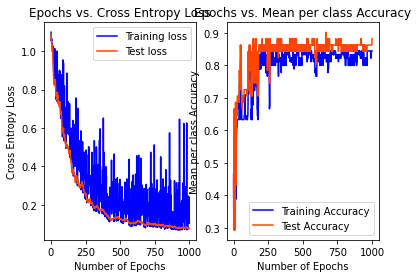

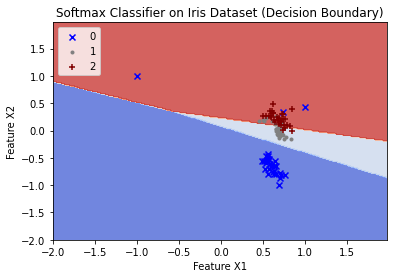

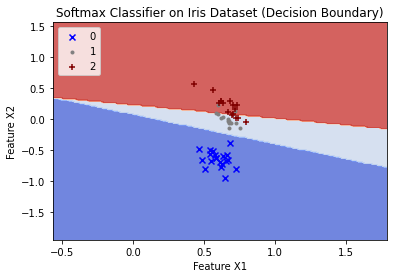

In [2]:
import numpy as np
import random, argparse
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel('ERROR')
class Softmax:
    # A softmax classifier
    __slots__ = ("epochs", "learningRate", "batchSize", "regStrength", "wt",
    "momentum", "velocity")
    def __init__(self, epochs, learningRate, batchSize, regStrength, momentum):
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.regStrength = regStrength
        self.momentum = momentum
        self.velocity = None
        self.wt = None

    def train(self, xTrain, yTrain, xTest, yTest):
        D = xTrain.shape[1] # dimensionality
        label = np.unique(yTrain)
        numOfClasses = len(label) # number of classes
        yTrainEnc = self.oneHotEncoding(yTrain, numOfClasses)
        yTestEnc = self.oneHotEncoding(yTest, numOfClasses)
        self.wt = 0.001 * np.random.rand(D, numOfClasses)
        self.velocity = np.zeros(self.wt.shape)
        trainLosses = []
        testLosses = []
        trainAcc = []
        testAcc = []
        for e in range(self.epochs): # run through epochs
            trainLoss = self.SGDWithMomentum(xTrain, yTrainEnc)
            testLoss, dw = self.computeLoss(xTest, yTestEnc)
            trainAcc.append(self.meanAccuracy(xTrain, yTrain))
            testAcc.append(self.meanAccuracy(xTest, yTest))
            trainLosses.append(trainLoss)
            testLosses.append(testLoss)
            print("{:d}\t->\tTraining Loss : {:.7f}\t|\tTest Loss : {:.7f}\t|\tTraining Accuracy : {:.7f}\t|\tTest Accuracy: {:.7f}"
                .format(e, trainLoss, testLoss, trainAcc[-1], testAcc[-1]))
        return trainLosses, testLosses, trainAcc, testAcc
    def SGDWithMomentum(self, x, y):
        losses = []
        randomIndices = random.sample(range(x.shape[0]), x.shape[0])
        x = x[randomIndices]
        y = y[randomIndices]
        for i in range(0, x.shape[0], self.batchSize):
                Xbatch = x[i:i+self.batchSize]
                ybatch = y[i:i+self.batchSize]
                loss, dw = self.computeLoss(Xbatch, ybatch)
                self.velocity = (self.momentum * self.velocity) + (self.learningRate * dw)
                self.wt -= self.velocity
                losses.append(loss)
                return np.sum(losses) / len(losses)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        prob = (e_x.T / np.sum(e_x, axis=1)).T
        return prob

    def computeLoss(self, x, yMatrix):
        numOfSamples = x.shape[0]
        scores = np.dot(x, self.wt)
        prob = self.softmax(scores)
        loss = -np.log(np.max(prob)) * yMatrix
        regLoss = (1/2)*self.regStrength*np.sum(self.wt*self.wt)
        totalLoss = (np.sum(loss) / numOfSamples) + regLoss
        grad = ((-1 / numOfSamples) * np.dot(x.T, (yMatrix - prob)))
        + (self.regStrength * self.wt)
        return totalLoss, grad

    def meanAccuracy(self, x, y):
        predY = self.predict(x)
        predY = predY.reshape((-1, 1))
        return np.mean(np.equal(y, predY))
    
    def predict(self, x):
        return np.argmax(x.dot(self.wt), 1)
        
    def oneHotEncoding(self, y, numOfClasses):
        y = np.asarray(y, dtype='int32')
        if len(y) > 1:
            y = y.reshape(-1)
        if not numOfClasses:
            numOfClasses = np.max(y) + 1
        yMatrix = np.zeros((len(y), numOfClasses))
        yMatrix[np.arange(len(y)), y] = 1
        return yMatrix

def plotGraph(trainLosses, testLosses, trainAcc, testAcc):
    plt.subplot(1, 2, 1)
    plt.plot(trainLosses, label="Training loss", c="b")
    plt.plot(testLosses, label="Test loss", c="orangered")
    plt.legend(loc='best')
    plt.title("Epochs vs. Cross Entropy Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.subplot(1, 2, 2)
    plt.plot(trainAcc, label="Training Accuracy", c="b")
    plt.plot(testAcc, label="Test Accuracy", c="orangered")
    plt.legend(loc='best')
    plt.title("Epochs vs. Mean per class Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Mean per class Accuracy")
    plt.show()
    
def readData(fname):
    dataMatrix = np.loadtxt(fname)
    np.random.shuffle(dataMatrix)
    X = dataMatrix[:, 1:]
    y = dataMatrix[:, 0].astype(int)
    y = y.reshape((-1, 1))
    y -= 1
    return X, y
def makeMeshGrid(x, y, h=0.02):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))
    return xx, yy
def plotContours(plt, model, xx, yy, **params):
    arr = np.array([xx.ravel(), yy.ravel()]).T
    b = np.ones(len(arr))
    arr = np.c_[arr,b]
    scores = np.dot(arr, sm.wt)
    prob = model.softmax(scores)
    Z = np.argmax(prob, axis=1) + 1
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
def plotDecisionBoundary(x, y):
    markers = ('x', '.', '+')
    colors = ('blue', 'grey', 'maroon')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    xx, yy = makeMeshGrid(x, y)
    plotContours(plt, sm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    for idx, cl in enumerate(np.unique(y)):
        xBasedOnLabel = x[np.where(y[:,0] == cl)]
        plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("Feature X1")
    plt.ylabel("Feature X2")
    plt.title("Softmax Classifier on Iris Dataset (Decision Boundary)")
    plt.xticks()
    plt.yticks()
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    trainX, trainY = readData("iris-train.txt") # Training data
    testX, testY = readData("iris-test.txt") # Testing data
    trainX = 2*trainX - 1;
    testX = 2*testX - 1;
    # Normalization must occur before bias
    b = np.ones(len(trainX))
    trainX = np.c_[trainX,b];
    b = np.ones(len(testX))
    testX = np.c_[testX,b];
    # Set default values
    epochs = int(1000)
    learningRate = float(0.07)
    batchSize = int(10)
    regStrength = float(0.001)
    momentum = float(0.05)
    sm = Softmax(epochs=epochs, learningRate=learningRate, batchSize=batchSize,
    regStrength=regStrength, momentum=momentum)
    trainLosses, testLosses, trainAcc, testAcc = sm.train(trainX, trainY, testX, testY)
    plotGraph(trainLosses, testLosses, trainAcc, testAcc)
    plotDecisionBoundary(trainX, trainY)
    plotDecisionBoundary(testX, testY)



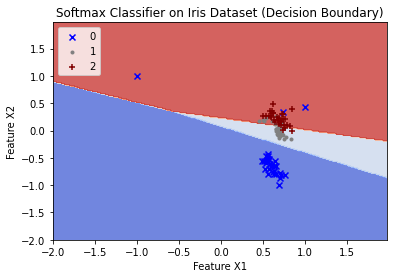

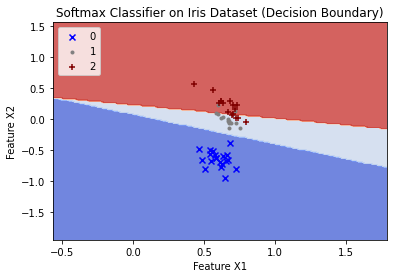

In [3]:
    plotDecisionBoundary(trainX, trainY)
    plotDecisionBoundary(testX, testY)
    

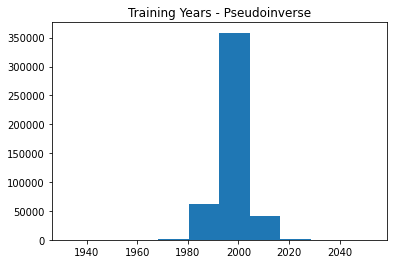

In [2]:
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
def loadMusicData(fname):
    dataMatrix = np.loadtxt(open(fname, "rb"), delimiter=",", skiprows=1)
    train = dataMatrix[0:463713,:]
    test = dataMatrix[463713:,:]
    trainYears = train[:,0]
    trainFeat = train[:,1:]
    testYears = test[:,0]
    testFeat = test[:,1:]
    return trainYears, trainFeat, testYears, testFeat

trainYears, trainFeat, testYears, testFeat = loadMusicData('YearPredictionMSD.txt')

def musicMSE(pred, gt, setname):
    mse = np.sum(np.square(gt-np.round(pred)))/len(setname)
    return mse

trainYears -= 1922; # smallest value of the data
testYears -= 1922; # smallest value of the data




b = np.mean(trainFeat,axis=0).copy();
trainFeat -= b;
testFeat -= b;
c = np.linalg.norm(trainFeat,axis=0).copy();

trainFeat /= c;
testFeat /= c;
d_1 = np.ones(len(trainFeat))
trainFeat_1 = np.c_[trainFeat,d_1]; #column concatenation one hot encoding? 
dataMatrix0 = np.insert(trainFeat, 0, trainYears, axis=1); # put train feat and trainyears together column-wise
dataMatrix1 = np.insert(testFeat, 0, testYears, axis=1);
dataMatrix = np.concatenate((dataMatrix0,dataMatrix1), axis=0);
d = np.ones(len(dataMatrix))

# Calculate pseudo-inverse and times with trainYears
dataMatrix = np.c_[dataMatrix,d];


w_pinv = np.matmul(np.linalg.pinv(trainFeat_1),trainYears);
trainYears_pinv = np.matmul(trainFeat_1,w_pinv);

plt.hist(trainYears_pinv + 1922);
plt.title('Training Years - Pseudoinverse')
plt.show()
# np.savetxt("YearPredictionMSD1.txt", dataMatrix, delimiter=",")


79.0
5954.510380343014
5969.389301001336


Text(0.5, 0, 'Epochs')

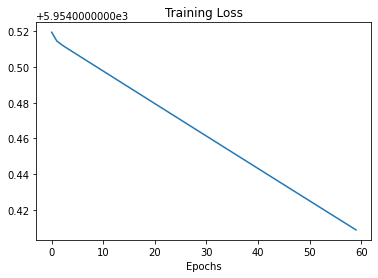

In [12]:
w = np.random.rand(1,90);
print(trainYears[0])
trainLosses = [];
for epochs in range(60):
    losses = [];
    for i in range(0, trainFeat.shape[0], 4):
        pred_diff = np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4];
        loss_grad = 2*(np.matmul(pred_diff,trainFeat[i:i+4]) + 0.01*np.sum(w));
        w -= (1e-5)*(loss_grad);
        loss = np.square(np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4])
        + 0.01*np.sum(np.square(w))
        losses.append(np.mean(loss))
    loss = np.sum(losses) / len(losses)
    trainLosses.append(loss)
def musicMSE(pred, gt, setname):
    mse = np.sum(np.square(gt-np.round(pred)))/len(setname)
    return mse
pred = np.matmul(w,trainFeat.T)
mse = musicMSE(pred, trainYears, trainFeat)
print(mse)
pred = np.matmul(w,testFeat.T)
mse = musicMSE(pred, testYears, testFeat)
print(mse)
plt.plot(trainLosses)
plt.title('Training Loss')
plt.xlabel('Epochs')


In [17]:
w = np.random.rand(1,90);
print(trainYears[0])
trainLosses = [];
for epochs in range(60):
    losses = [];
    for i in range(0, trainFeat.shape[0], 4):
        pred_diff = np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4];
        w_abs = w.copy()
        w_abs[w_abs < 0] = -1
        w_abs[w_abs == 0] = 0
        w_abs[w_abs > 0] = 1
        loss_grad = 2*(np.matmul(pred_diff,trainFeat[i:i+4])) + 0.01*np.sum(w_abs);
        w -= (1e-5)*(loss_grad);
        loss = np.square(np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4])
        + 0.01*np.sum(w)
        losses.append(np.mean(loss))
    loss = np.sum(losses) / len(losses)
    print(loss)
    trainLosses.append(loss)
plt.plot(trainLosses, label="Train loss")

79.0
5954.406906965784


In [18]:
from scipy.special import factorial



79.0
5969.389301001336


Text(0.5, 0, 'Epochs')

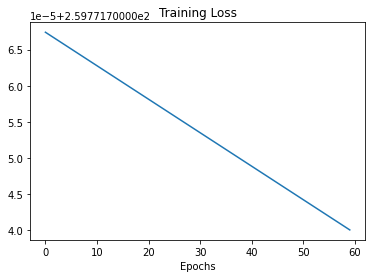

In [21]:
w = np.random.rand(1,90);
print(trainYears[0])
trainLosses = [];
for epochs in range(60):
    losses = [];
    for i in range(0, trainFeat.shape[0], 4):
        pred_diff = np.exp(np.matmul(w,trainFeat[i:i+4].T)) - trainYears[i:i+4];
        loss_grad = np.matmul(pred_diff,trainFeat[i:i+4]);
        w -= (1e-8)*(loss_grad);
        loss = np.exp(np.matmul(w,trainFeat[i:i+4].T)) - np.multiply(trainYears[i:i+4],np.matmul(w,trainFeat[i:i+4].T))
        loss += np.log(factorial(trainYears[i:i+4]))
        losses.append(np.mean(loss))
    loss = np.sum(losses) / len(losses)
    trainLosses.append(loss)

pred = np.matmul(w,testFeat.T)
mse = musicMSE(pred, testYears, testFeat)
print(mse)
plt.plot(trainLosses)
plt.title('Training Loss')
plt.xlabel('Epochs')


79.0
5969.389301001336


Text(0.5, 0, 'Epochs')

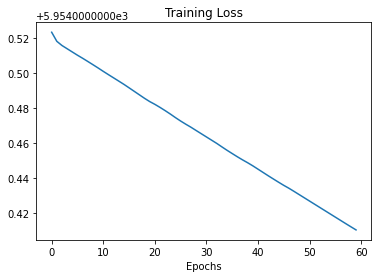

In [23]:
w = np.random.rand(1,90);
print(trainYears[0])
trainLosses = [];
for epochs in range(60):
    losses = [];
    for i in range(0, trainFeat.shape[0], 4):
        pred_diff = np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4];
        w_abs = w.copy()
        w_abs[w_abs < 0] = -1
        w_abs[w_abs == 0] = 0
        w_abs[w_abs > 0] = 1
        loss_grad = 2*(np.matmul(pred_diff,trainFeat[i:i+4])) + 0.01*np.sum(w_abs);
        w -= (1e-5)*(loss_grad);
        loss = np.square(np.matmul(w,trainFeat[i:i+4].T) - trainYears[i:i+4])
        + 0.01*np.sum(w)
        losses.append(np.mean(loss))
    loss = np.sum(losses) / len(losses)
    trainLosses.append(loss)
#plt.plot(trainLosses, label="Train loss")
pred = np.matmul(w,testFeat.T)
mse = musicMSE(pred, testYears, testFeat)
print(mse)
plt.plot(trainLosses)
plt.title('Training Loss')
plt.xlabel('Epochs')